## Set up

### Set up for Colab

In [2]:
# For runing notebook in colab
from google.colab import drive
drive.mount('/content/drive')
import os
root_of_repository = '/content/drive/MyDrive/ADL/Project/'
os.chdir(root_of_repository)

Mounted at /content/drive


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 30.3 MB/s 
     |████████████████████████████████| 182 kB 79.0 MB/s 
     |████████████████████████████████| 7.6 MB 68.8 MB/s 


### Packages

In [4]:
import torch
from transformers import BertModel, BertTokenizer
from transformers import logging
logging.set_verbosity_error()
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

import numpy as np
import pandas as pd
import json
import copy
import time
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [5]:
from classifier_utils import SentimentClassifier, StackedClassifier, test

## Data Preprocessing

In [6]:
SEQ_LENGTH = 128
BATCH_SIZE = 8
LABEL_DICT = {'fear':0, 'neutral':1, 'sad':2, 'surprise':3, 'angry':4, 'happy':5} # Mapping label code and meaning
TOKENIZER = BertTokenizer.from_pretrained("hfl/chinese-bert-wwm-ext") # Hugging face BertTokenizer to load pretrain model
DEVELOPMENT_SET_PATH = 'data/usual_train.txt'
TEST_SET_PATH = 'data/usual_test_labeled.txt'

def convert_text_to_token(tokenizer, sentence, seq_length):
    """Tokenize sentence

    Args:
        tokenizer (PreTrainedTokenizer): a pretrained tokenizer with special token set to 
            {'unk_token': '[UNK]', 'sep_token': '[SEP]', 
             'pad_token': '[PAD]', 'cls_token': '[CLS]', 
             'mask_token': '[MASK]'}
        sentence (str): 
        seq_length (int): length of maximum input sentence accepted
    
    Returns: tuple(word_ids, segments, attention_masks)
        word_ids (list): tokenized sentence
        segments (list): label segmentation of original sentence and padding
        attention_masks (list): label whether the word is masked
    """ 
    tokens = tokenizer.tokenize(sentence) # Tokenize the sentence
    tokens = ["[CLS]"] + tokens + ["[SEP]"] # Add [CLS] before token and [SEP] after token
    word_ids = tokenizer.convert_tokens_to_ids(tokens) # Generate list of word id
    segments = [0] * len(word_ids) # Label whether it is segmented
    attention_masks = [1] * len(word_ids) # Label whether the word is masked
    # Chop or pad the sentence into a single length - seq_length
    if len(word_ids) < seq_length: # Padding
        length_to_pad = seq_length - len(word_ids)
        word_ids += [0] * length_to_pad # [0] is the index of word "PAD" in the vocabulary table
        segments += [1] * length_to_pad # [1] denotes that this part of words are PAD
        attention_masks += [0] * length_to_pad # Change attention mask of PAD part as [0]
    else: # Chopping
        word_ids = word_ids[:seq_length]
        segments = segments[:seq_length]
        attention_masks = attention_masks[:seq_length]
    assert len(word_ids) == len(segments) == len(attention_masks)
    return word_ids, segments, attention_masks

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [7]:
def genDataLoader(data_type):
    '''Construct dataset loader

    Args:
        data_type (str): 'train' in training, 'val' in validating, 'test' in testing
    '''
    if data_type == 'test':
        with open(TEST_SET_PATH, encoding='utf8') as file:
            data = json.load(file)
    else:
        with open(DEVELOPMENT_SET_PATH, encoding='utf8') as file:
            data = json.load(file)
            # TESTING_STAGE
            if TESTING:
                dev_set, _ = train_test_split(data, train_size=160, random_state=4995)
                train_set, val_set = train_test_split(dev_set, test_size=0.2, random_state=4995)
            else:
                train_set, val_set = train_test_split(data, test_size=0.2, random_state=4995)
            data = train_set if data_type == 'train' else val_set
    ids_pool = []
    segments_pool = []
    masks_pool = []
    target_pool = []
    count = 0
    # Process all the sentences
    for each in data:
        cur_ids, cur_type, cur_mask = convert_text_to_token(TOKENIZER, each['content'], seq_length = SEQ_LENGTH)
        ids_pool.append(cur_ids)
        segments_pool.append(cur_type)
        masks_pool.append(cur_mask)
        cur_target = LABEL_DICT[each['label']]
        target_pool.append([cur_target])
        count += 1
        if count % 2000 == 0:
            print(f'Processed {count} sentences for {data_type}')
    # Construct Data Generater
    data_gen = TensorDataset(torch.LongTensor(np.array(ids_pool)),
                             torch.LongTensor(np.array(segments_pool)),
                             torch.LongTensor(np.array(masks_pool)),
                             torch.LongTensor(np.array(target_pool)))
    sampler = RandomSampler(data_gen)
    loader = DataLoader(data_gen, sampler=sampler, batch_size=BATCH_SIZE)
    return loader

In [8]:
TESTING = False
train_datagen = genDataLoader('train')
val_datagen = genDataLoader('val')
test_datagen = genDataLoader('test')

Processed 2000 sentences for train
Processed 4000 sentences for train
Processed 6000 sentences for train
Processed 8000 sentences for train
Processed 10000 sentences for train
Processed 12000 sentences for train
Processed 14000 sentences for train
Processed 16000 sentences for train
Processed 18000 sentences for train
Processed 20000 sentences for train
Processed 22000 sentences for train
Processed 2000 sentences for val
Processed 4000 sentences for val
Processed 2000 sentences for test
Processed 4000 sentences for test


In [9]:
BEST_MODEL_FOLDER = 'result/model_disallow/'  # Path to save best model
TRAINING_LOGS_FOLDER = 'result/training_disallow/'  # Path to save training logs
TESTING_LOGS_FOLDER = 'result/testing/'  # Path to save testing logs

## Evaluating

In [10]:
# All pretrain models in chinese
MODELS_PATHS_UNITS = {
    'BERT': ('bert-base-chinese', 768),
    'BERT-wwm': ('hfl/chinese-bert-wwm-ext', 768),
    'RoBERTa': ('uer/chinese_roberta_L-12_H-768', 768),
    'RoBERTa-wwm': ('hfl/chinese-roberta-wwm-ext', 768),
    'RoBERTa-wwm-large': ('hfl/chinese-roberta-wwm-ext-large', 1024),
    '3L RoBERTa-wwm': ('hfl/rbt3', 768),
    '3L RoBERTa-wwm-large': ('hfl/rbtl3', 1024),
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

### Training Performance

In [13]:
training_results = []
for model_name in tqdm(MODELS_PATHS_UNITS.keys()):
    log_path = f'{TRAINING_LOGS_FOLDER}{model_name}.pickle'
    if os.path.exists(log_path):
        training_log = pd.read_pickle(log_path)
        training_results.append(training_log)
    else:
        print(log_path, "doesn't exists")
training_result = pd.concat(training_results, axis=0)
training_result.to_excel('output/training_result.xlsx', index=False)

  0%|          | 0/7 [00:00<?, ?it/s]

### Model Stacking

In [14]:
# Calculate model weight base on performance on validation set
weight_to_stack = training_result \
    .groupby(['Model'], as_index=False) \
    .apply(lambda g: g[g['validation_f1'] == g['validation_f1'].max()]) \
    .assign(weight=lambda r: r['validation_f1'] / r['validation_f1'].sum()) \
    .loc[:, ['Model', 'weight']] \
    .reset_index(drop=True)
weight_to_stack.to_excel('result/model/model_weight.xlsx', index=False)
weight_to_stack

,Model,weight
0,3L RoBERTa-wwm,0.139229
1,3L RoBERTa-wwm-large,0.139066
2,BERT,0.142522
3,BERT-wwm,0.142972
4,RoBERTa,0.145639
5,RoBERTa-wwm,0.145295
6,RoBERTa-wwm-large,0.145277


In [15]:
stack_weights = pd.read_excel('result/model/model_weight.xlsx').set_index('Model').to_dict()['weight']
stack_weights

{'3L RoBERTa-wwm': 0.1392292053884837,
 '3L RoBERTa-wwm-large': 0.1390655415400497,
 'BERT': 0.1425224108327093,
 'BERT-wwm': 0.1429716061476956,
 'RoBERTa': 0.1456389316129748,
 'RoBERTa-wwm': 0.1452953551789674,
 'RoBERTa-wwm-large': 0.1452769492991196}

In [16]:
# Load Model
base_models = {}
for model_name in tqdm(MODELS_PATHS_UNITS.keys()):
    # Initialize model
    sentiment_classifier = SentimentClassifier(num_classes=6, 
                                               model_name=model_name, 
                                               pretrain_path=MODELS_PATHS_UNITS[model_name][0], 
                                               hidden_size=MODELS_PATHS_UNITS[model_name][1]).to(DEVICE)
    # Load model parameters
    model_path = f'{BEST_MODEL_FOLDER}best_{model_name}.pth' if not TESTING else f'{BEST_MODEL_FOLDER}best_testing_{model_name}.pth'
    sentiment_classifier.load_state_dict(torch.load(model_path, map_location=DEVICE))

    base_models[model_name] = sentiment_classifier
    gc.collect()

  0%|          | 0/7 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/412M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/412M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/468 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/409M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/412M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/828 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/156M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248M [00:00<?, ?B/s]

In [17]:
stacked_model = StackedClassifier(base_models, stack_weights, device=DEVICE)

### Testing Performance

In [18]:
REPLACE_EXIST = True
for model_name, sentiment_classifier in tqdm(list(base_models.items()) + [('Stacked-model', stacked_model)]):
    result_log_path = f'{TESTING_LOGS_FOLDER}{model_name}.pickle'
    if not os.path.exists(result_log_path) or REPLACE_EXIST:
        # Evaluate on testset
        loss, accuracy, f1, inference_time = test(sentiment_classifier, test_datagen, device=DEVICE)
        # Logging
        result = pd.DataFrame([[model_name, loss, 100*accuracy, 100*f1, inference_time / len(test_datagen)]],
                              columns=['Model', 'Loss', 'Accuracy (%)', 'Macro F1 (%)', 'Inference Time (per sentence)'])
        result.to_pickle(result_log_path)

  0%|          | 0/8 [00:00<?, ?it/s]

Test set: Average loss: 0.6528, Accuracy: 3864/5000 (77.2800%), Macro F1: 74.3372%, took 37.5s
Test set: Average loss: 0.6363, Accuracy: 3909/5000 (78.1800%), Macro F1: 75.2372%, took 35.1s
Test set: Average loss: 0.6038, Accuracy: 3927/5000 (78.5400%), Macro F1: 75.4014%, took 34.8s
Test set: Average loss: 0.5976, Accuracy: 3923/5000 (78.4600%), Macro F1: 75.6282%, took 35.4s
Test set: Average loss: 0.6069, Accuracy: 3905/5000 (78.1000%), Macro F1: 75.5152%, took 121.3s
Test set: Average loss: 0.6943, Accuracy: 3742/5000 (74.8400%), Macro F1: 71.3529%, took 8.9s
Test set: Average loss: 0.7162, Accuracy: 3739/5000 (74.7800%), Macro F1: 72.0852%, took 15.2s
Test set: Average loss: 1.3101, Accuracy: 3959/5000 (79.1800%), Macro F1: 76.5250%, took 281.6s


In [52]:
testing_results = []
for model_name, sentiment_classifier in tqdm(list(base_models.items()) + [('Stacked-model', stacked_model)]):
    log_path = f'{TESTING_LOGS_FOLDER}{model_name}.pickle'
    if os.path.exists(log_path):
        testing_log = pd.read_pickle(log_path)
        testing_results.append(testing_log)
testing_result = pd.concat(testing_results, axis=0)
train_time_agg = training_result.groupby('Model', as_index=False) \
    .apply(lambda x: pd.Series({'Training Time (per sentence in 1 epoch)': x['time_usage'].sum() / (len(train_datagen) * x['time_usage'].count())}))
testing_result = testing_result.merge(train_time_agg, how='left')
testing_result.to_excel('output/testing_result.xlsx', index=False)
testing_result

  0%|          | 0/8 [00:00<?, ?it/s]

,Model,Loss,Accuracy (%),Macro F1 (%),Inference Time (per sentence),Training Time (per sentence in 1 epoch)
0,BERT,0.652830,77.28,74.337223,0.059932,0.200885
1,BERT-wwm,0.636283,78.18,75.237225,0.056208,0.193801
2,RoBERTa,0.603808,78.54,75.401370,0.055755,0.200856
3,RoBERTa-wwm,0.597588,78.46,75.628218,0.056632,0.193726
4,RoBERTa-wwm-large,0.606937,78.10,75.515195,0.194151,0.685419
5,3L RoBERTa-wwm,0.694275,74.84,71.352932,0.014206,0.052430
6,3L RoBERTa-wwm-large,0.716177,74.78,72.085199,0.024284,0.086637
7,Stacked-model,1.310078,79.18,76.525006,0.450529,NaN


### Confusion Matrix of stacking model

In [53]:
model = stacked_model
y_test = []
pred = []
for (word_ids, token_types, attention_masks, y) in test_datagen:
    word_ids, token_types, attention_masks, y = word_ids.to(DEVICE), token_types.to(DEVICE), attention_masks.to(DEVICE), y.to(DEVICE)
    with torch.no_grad():
        y_ = model(word_ids, token_type_ids=token_types, attention_mask=attention_masks)
    y_test += y.squeeze().tolist()
    pred += y_.argmax(dim=1).tolist() # Obtain the maximum probability

array([[1254,   13,   26,  161,   43,   11],
       [  25,  807,   69,   42,   37,   10],
       [  28,   64,  826,   56,   33,   11],
       [ 122,   23,   67,  660,    9,   19],
       [  45,    9,   31,   15,  258,   16],
       [  14,    4,    4,   23,   11,  154]])

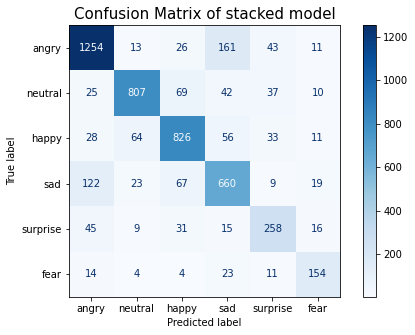

In [86]:
fig, ax = plt.subplots(figsize=(8, 5))
label_order = ['angry', 'neutral', 'happy', 'sad', 'surprise', 'fear']
label_code_order = [LABEL_DICT[name] for name in label_order]
cm = confusion_matrix(y_test, pred, labels=label_code_order)
ConfusionMatrixDisplay(cm, display_labels = label_order) \
    .plot(cmap=plt.cm.Blues,
          values_format='g',
          ax=ax)
plt.title('Confusion Matrix of stacked model', {'fontsize': 15})
plt.savefig('output/matrix.png', dpi=450)
plt.show()